<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Let's build our first ANN!

Steps involved:

- Select and preprocess data (select variables/features, normalize and/or standardize, split train and test data)
- Select model architecture and hyperparameters
- Start training your model
- Track the training loss and validationeat.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import keras
import sklearn

First create some toy data to play with.

In [2]:
np.random.seed(123)

# set the time range from 1999-2019
times = pd.date_range("1999-01-01", "2019-12-31", name="time")

# create an "annual cycle"
annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 365.25 - 0.28))

# create some base "temperatures"
base = 10 + 15 * annual_cycle.reshape(-1, 1)
tmin_values = base + 3 * np.random.randn(annual_cycle.size, 1)
tmax_values = base + 10 + 3 * np.random.randn(annual_cycle.size, 1)

# let's put these dummy temperatures into an xarray dataset
ds = xr.Dataset(
    {
        "tmin": (("time", "location"), tmin_values),
        "tmax": (("time", "location"), tmax_values),
    },
    {"time": times, "location": ["IA"]},
)

In [3]:
# what does this look like
ds

<xarray.Dataset> Size: 184kB
Dimensions:   (time: 7670, location: 1)
Coordinates:
  * time      (time) datetime64[ns] 61kB 1999-01-01 1999-01-02 ... 2019-12-31
  * location  (location) <U2 8B 'IA'
Data variables:
    tmin      (time, location) float64 61kB -8.037 -1.83 ... -4.857 -1.792
    tmax      (time, location) float64 61kB 9.607 7.746 -1.154 ... 10.84 7.317

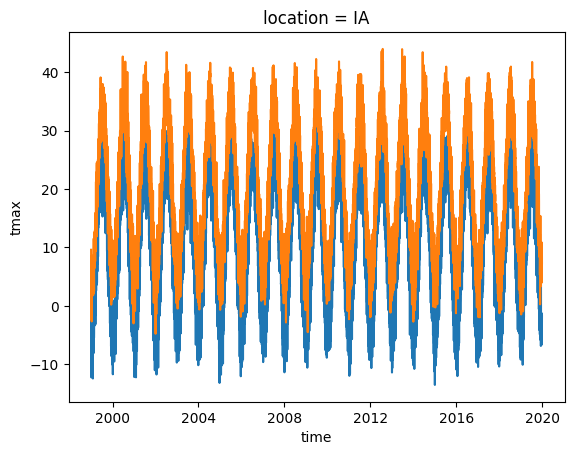

In [4]:
# some time series plots
ds.tmin.plot()
ds.tmax.plot()
plt.show()

## Lets now preprocess our dataset in preparation for training

- Lets structure the supervised learning problem (what is the input/feature(s)/label?)
- Since this is time series data and there is autocorrelation, we will split data into train and test set using years rather than randomly splitting data
- Standardize and normalize the training set

In [5]:
# split by years
train = ds.sel(time=slice('1999-01-01T00:00:00.000000000','2014-12-31T00:00:00.000000000'))
test = ds.sel(time=slice('2015-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))

For random train test splitting, check out

`from sklearn.model_selection import train_test_split`

Now lets set up the input and label.

In [6]:
input_train = train.tmin
label_train = train.tmax

And finally, let's go ahead and min-max scale our training data. We can levarage the sklearn function that will save our min and max values from the training set for us.

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
# create our scaler object
scaler_input = MinMaxScaler()
scaler_label = MinMaxScaler()

In [9]:
scaler_input.fit(input_train)

MinMaxScaler()

In [10]:
scaler_label.fit(label_train)

MinMaxScaler()

In [11]:
print(scaler_input.data_max_)
print(scaler_input.data_min_)

[33.52620933]
[-13.18084936]


In [12]:
print(scaler_label.data_max_)
print(scaler_label.data_min_)

[43.97570471]
[-4.77030373]


In [13]:
input_train_scaled = scaler_input.transform(input_train)
label_train_scaled = scaler_label.transform(label_train)

Let's confirm that this worked!

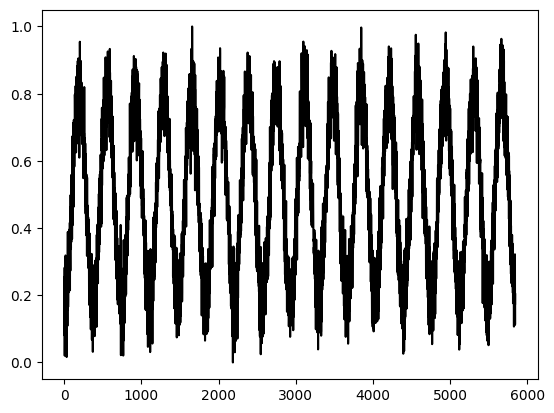

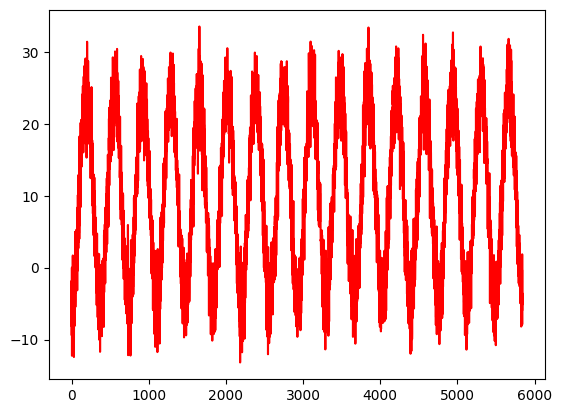

In [14]:
plt.plot(range(0,input_train_scaled.shape[0]), input_train_scaled, c='k')
plt.show()
plt.plot(range(0,input_train_scaled.shape[0]), input_train, c='r')
plt.show()

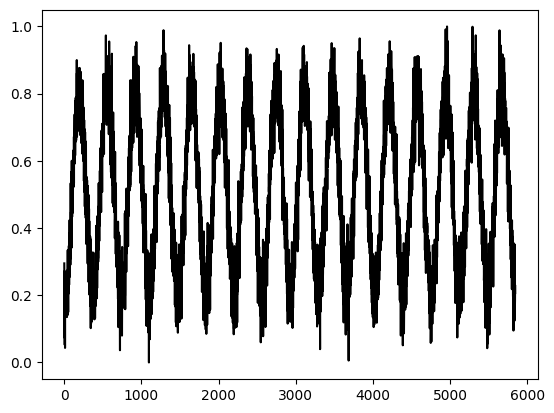

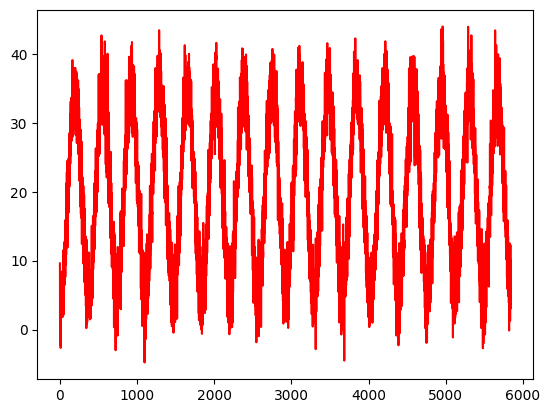

In [15]:
plt.plot(range(0,label_train_scaled.shape[0]), label_train_scaled, c='k')
plt.show()
plt.plot(range(0,label_train_scaled.shape[0]), label_train, c='r')
plt.show()

Now that our toy data in ready, including our input variable and the label, lets build our ANN (artificial neural network)

# ANN Time! (regression type)

Documentation: https://keras.io/api/models/sequential/

In [16]:
model = keras.Sequential() # instantiate model object

Creating our input layer (not required, but I recommend this because it lets the model get built continuously as you are adding layers rather than waiting till the end to build).

In [17]:
model.add(keras.Input(shape=(1,), name="input_layer"))

Docs: https://keras.io/api/layers/core_layers/input/

Now lets add our hidden layers

In [18]:
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))

Docs: https://keras.io/api/layers/core_layers/dense/

Since this is a regression task, let's let the last layer be a single output value (per sample) with linear activation (aka None).

In [19]:
model.add(keras.layers.Dense(units=1))

Now compiling our model. We will use gradient descent (with momentum) optimizer called SGD and MSE as a loss function.

For more options and docs, see:

- https://keras.io/api/optimizers/
- https://keras.io/api/losses/

In [20]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='mse'
)

What does our model "look" like?

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

Call model.fit to train! YAY :)

Documentation: https://keras.io/api/models/model_training_apis/

In [22]:
history = model.fit(
    x=input_train_scaled,
    y=label_train_scaled,
    batch_size=32,
    epochs=20,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0651 - val_loss: 0.0134
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0118 - val_loss: 0.0100
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 12/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Lets plot our training and validation loss curves.

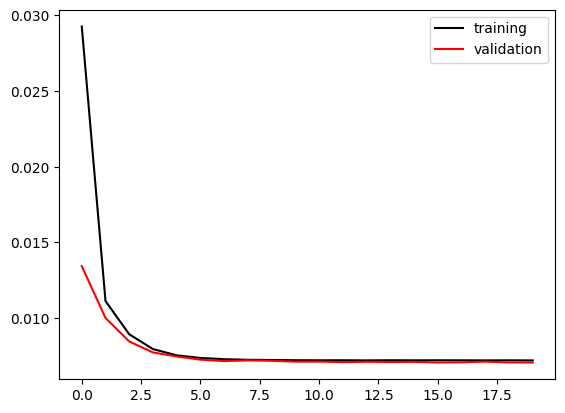

In [23]:
plt.plot(range(0,20), history.history['loss'], c='k', label='training')
plt.plot(range(0,20), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

# Now lets do inference

How does our model perform on the testing set?

Rescale our test data using our earlier scaler objects

In [24]:
input_test = test.tmin
label_test = test.tmax

input_test_scaled = scaler_input.transform(input_test)
label_test_scaled = scaler_label.transform(label_test)

Quick double check!

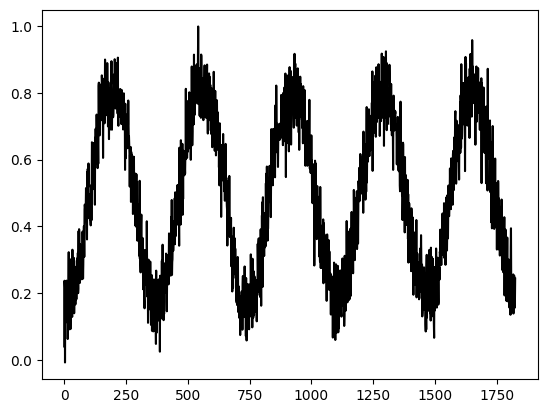

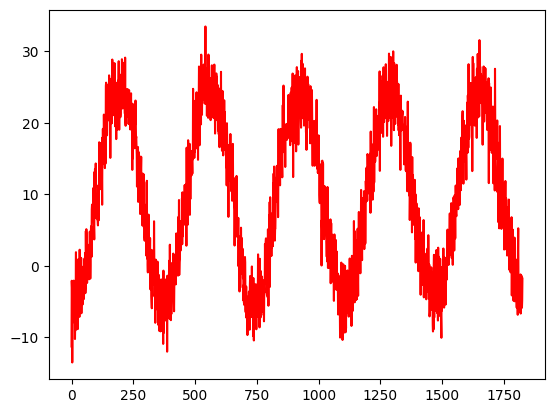

In [25]:
plt.plot(range(0,input_test_scaled.shape[0]), input_test_scaled, c='k')
plt.show()
plt.plot(range(0,input_test_scaled.shape[0]), input_test, c='r')
plt.show()

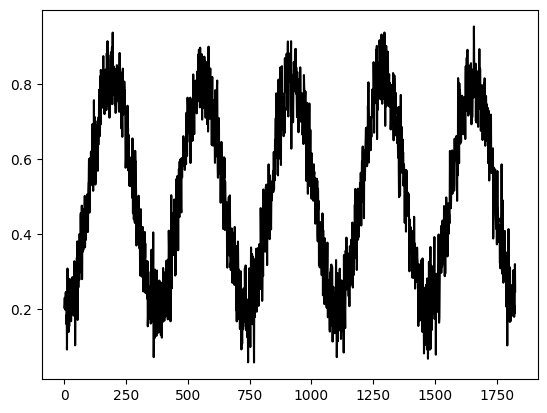

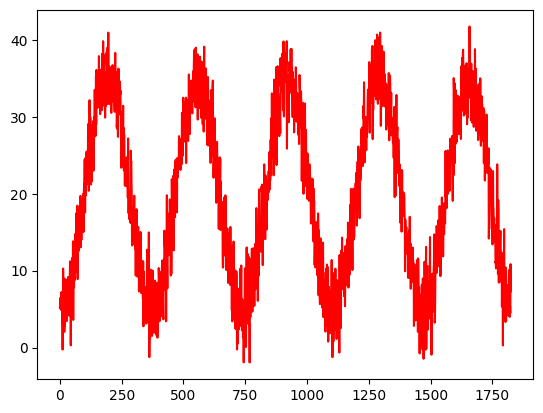

In [26]:
plt.plot(range(0,label_test_scaled.shape[0]), label_test_scaled, c='k')
plt.show()
plt.plot(range(0,label_test_scaled.shape[0]), label_test, c='r')
plt.show()

In [27]:
# to predict, use predict call
predictions = model.predict(
    x=input_test_scaled,
)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


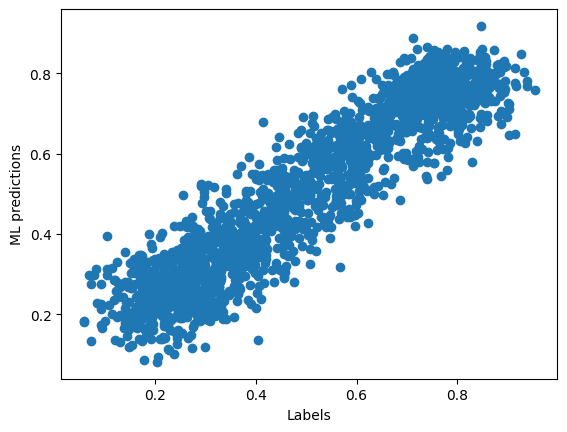

In [28]:
plt.scatter(label_test_scaled, predictions)
plt.xlabel('Labels')
plt.ylabel('ML predictions')
plt.show()

In [29]:
# MSE
# np.mean(square(y_true - y_pred))
np.mean(np.square(label_test_scaled - predictions))

0.006868718024703924

## Now, let's train a new ANN for a classification task Part 1
We will first do an example with sigmoid as the final output layer activation and integer encoding for the labels.

In [30]:
# split training and testing data by years
train = ds.sel(time=slice('1999-01-01T00:00:00.000000000','2014-12-31T00:00:00.000000000'))
test = ds.sel(time=slice('2015-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))

In [31]:
# minimum temperature will be the input feature and maximum temperature will be the ground truth
input_train = train.tmin
label_train = train.tmax

In [32]:
# create our scaler object for the input feature
# transform as before
scaler_input = MinMaxScaler()
scaler_input.fit(input_train)
input_train_scaled = scaler_input.transform(input_train)

In [33]:
# for our labels, we will need to convert the continuous data into binary classes
# we set values greater than or equal to 20 degrees as the positive class (1)
# anything less will be the negative class (0)
label_train_scaled = xr.where(label_train >= 20, 1, 0)

(array([2909.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2935.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

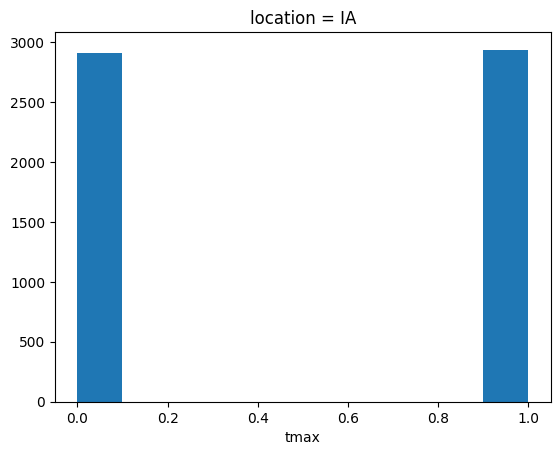

In [34]:
# check for class imbalance (looks fine!)
label_train_scaled.isel(location=0).plot.hist()

In [35]:
# now, let's create a new ANN
# most things will be consistent to the earlier example
model = keras.Sequential() # instantiate model object
model.add(keras.Input(shape=(1,), name="input_layer"))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))

In [36]:
# our first change is the output layer activation function (now sigmoid instead of linear)
model.add(keras.layers.Dense(units=1, activation='sigmoid'))

In [37]:
# and our loss function now is binary cross entropy
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.BinaryCrossentropy()
)

In [38]:
# check out the new model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 8)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(
    x=input_train_scaled,
    y=label_train_scaled,
    batch_size=32,
    epochs=20,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6794 - val_loss: 0.6526
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6506 - val_loss: 0.6185
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6172 - val_loss: 0.5795
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5767 - val_loss: 0.5342
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5377 - val_loss: 0.4836
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4866 - val_loss: 0.4261
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4210 - val_loss: 0.3665
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3691 - val_loss: 0.3215
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3282 - val_loss: 0.2866
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3025 - val_loss: 0.2590
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2744 - val_loss: 0.2378
Epoch 12/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

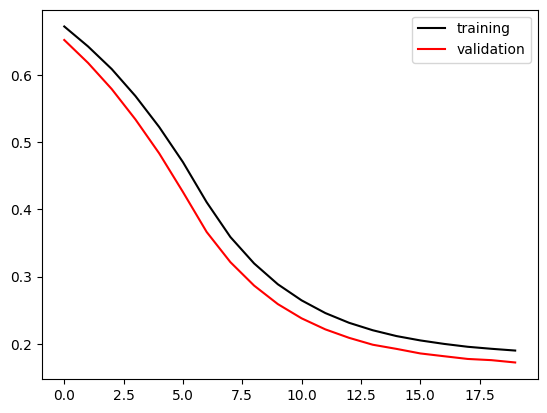

In [40]:
plt.plot(range(0,20), history.history['loss'], c='k', label='training')
plt.plot(range(0,20), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

## ANN Classification Part 2
We now do an example with softmax as the final output layer activation and one-hot encoding for the labels.

In [41]:
# steps here as earlier:

# split training and testing data by years
train = ds.sel(time=slice('1999-01-01T00:00:00.000000000','2014-12-31T00:00:00.000000000'))
test = ds.sel(time=slice('2015-01-01T00:00:00.000000000','2019-12-31T00:00:00.000000000'))

# minimum temperature will be the input feature and maximum temperature will be the ground truth
input_train = train.tmin
label_train = train.tmax

# create our scaler object for the input feature
# transform as before
scaler_input = MinMaxScaler()
scaler_input.fit(input_train)
input_train_scaled = scaler_input.transform(input_train)

# for our labels, we will need to convert the continuous data into binary classes
# we set values greater than or equal to 20 degrees as the positive class (1)
# anything less will be the negative class (0)
label_train = xr.where(label_train >= 20, 1, 0)

In [42]:
label_train

<xarray.DataArray 'tmax' (time: 5844, location: 1)> Size: 47kB
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])
Coordinates:
  * time      (time) datetime64[ns] 47kB 1999-01-01 1999-01-02 ... 2014-12-31
  * location  (location) <U2 8B 'IA'

In [43]:
# Now, let's one hot encode our binary classes
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [44]:
onehot.fit(label_train)
label_train_scaled = onehot.transform(label_train).toarray()

In [45]:
label_train_scaled

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [46]:
# now, let's create a new ANN
# most things will be consistent to the earlier example
model = keras.Sequential() # instantiate model object
model.add(keras.Input(shape=(1,), name="input_layer"))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))
model.add(
    keras.layers.Dense(units=8, activation=keras.activations.relu))

In [47]:
# our first change is the output layer activation function (now softmax with 2 classes/nodes)
model.add(keras.layers.Dense(units=2, activation='softmax'))

In [48]:
# and our loss function now is categorical cross entropy
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss=keras.losses.CategoricalCrossentropy()
)

In [49]:
# check out the new model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 8)                   │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106 (424.00 B)

 Trainable params: 106 (424.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(
    x=input_train_scaled,
    y=label_train_scaled,
    batch_size=32,
    epochs=20,
    verbose='auto',
    validation_split=0.1,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6815 - val_loss: 0.6371
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6263 - val_loss: 0.5744
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5666 - val_loss: 0.4964
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4845 - val_loss: 0.4106
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4014 - val_loss: 0.3366
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3339 - val_loss: 0.2777
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2749 - val_loss: 0.2391
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2513 - val_loss: 0.2145
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2255 - val_loss: 0.1995
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2120 - val_loss: 0.1873
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1982 - val_loss: 0.1807
Epoch 12/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

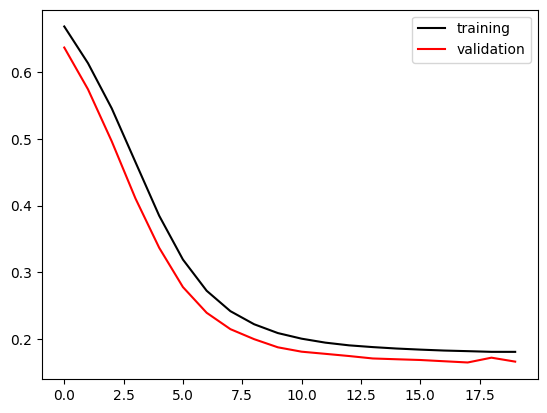

In [51]:
plt.plot(range(0,20), history.history['loss'], c='k', label='training')
plt.plot(range(0,20), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()